In [1]:
import torch 
from fastai.vision.all import *
import cv2
import numpy as np
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageFile
from PIL import Image
ImageFile.LOAD_TRUNCATED_IMAGES = True
from torchvision.utils import save_image
import os
import torchvision.transforms as transforms

In [2]:
def label_func(f):
    if f[0].isupper():
        return 'cat' 
    else: 
        return 'dog' 

In [3]:
path=Path('original_pet') 
files=get_image_files(path)
dls=ImageDataLoaders.from_name_func(path,files,label_func,item_tfms=Resize(512)) 

In [4]:
path_r=Path('random_pet_one')   #랜덤박스넣은사진
files_r=get_image_files(path_r)
dls_r=ImageDataLoaders.from_name_func(path_r,files_r,label_func,item_tfms=Resize(512)) 

# 학습

In [10]:
lrnr=cnn_learner(dls,resnet34,metrics=error_rate)
lrnr.fine_tune(1)

/home/csy/anaconda3/envs/temp_csy/lib/python3.8/site-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/home/csy/anaconda3/envs/temp_csy/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/csy/anaconda3/envs/temp_csy/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,0.135569,0.021936,0.006089,00:37


epoch,train_loss,valid_loss,error_rate,time
0,0.033069,0.016387,0.003383,00:47


In [11]:
net1=lrnr.model[0]
net2=lrnr.model[1]

In [12]:
net2 = torch.nn.Sequential(
    torch.nn.AdaptiveAvgPool2d(output_size=1), 
    torch.nn.Flatten(),
    torch.nn.Linear(512,out_features=2,bias=False))

In [13]:
net=torch.nn.Sequential(net1,net2)

In [14]:
lrnr2=Learner(dls,net,metrics=accuracy) 

In [15]:
lrnr2.fine_tune(5) 

epoch,train_loss,valid_loss,accuracy,time
0,0.223036,1.529223,0.627199,00:46


epoch,train_loss,valid_loss,accuracy,time
0,0.122068,0.748446,0.734100,00:46
1,0.115533,0.599636,0.785521,00:47
2,0.066296,0.100066,0.966847,00:46
3,0.029701,0.049993,0.981055,00:46
4,0.009684,0.052729,0.978349,00:46


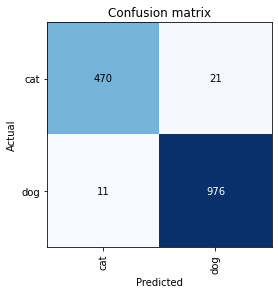

In [16]:
interp = ClassificationInterpretation.from_learner(lrnr2)
interp.plot_confusion_matrix()

In [17]:
lrnr_r=cnn_learner(dls_r,resnet34,metrics=error_rate)
lrnr_r.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.140315,0.002963,0.000677,00:36


epoch,train_loss,valid_loss,error_rate,time
0,0.000983,0.000002,0.000000,00:47


In [18]:
net1_r=lrnr_r.model[0]
net2_r=lrnr_r.model[1]

In [19]:
net2_r = torch.nn.Sequential(
    torch.nn.AdaptiveAvgPool2d(output_size=1), 
    torch.nn.Flatten(),
    torch.nn.Linear(512,out_features=2,bias=False))

In [20]:
net_r=torch.nn.Sequential(net1_r,net2_r)

In [21]:
lrnr2_r=Learner(dls_r,net_r,metrics=accuracy) 

In [22]:
lrnr2_r.fine_tune(5) 

epoch,train_loss,valid_loss,accuracy,time
0,0.009831,0.000473,1.000000,00:47


epoch,train_loss,valid_loss,accuracy,time
0,0.000008,0.000001,1.000000,00:47
1,0.000002,0.000000,1.000000,00:47
2,0.000001,0.000000,1.000000,00:46
3,0.000000,0.000000,1.000000,00:46
4,0.000000,0.000000,1.000000,00:46


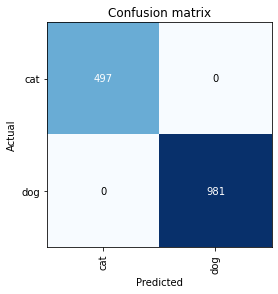

In [23]:
interp_r = ClassificationInterpretation.from_learner(lrnr2_r)
interp_r.plot_confusion_matrix()

# class

In [24]:
def score_cam(model, img, class_index):
    def forward_hook(module, input, output):
        module.forward_output = output

    def backward_hook(module, grad_in, grad_out):
        grad_in_tensor = grad_in[0]
        module.backward_output = grad_in_tensor

    # target_layer_output = model.layer4  
    target_layer_output = model[0][-1]
    target_layer_output.register_forward_hook(forward_hook)
    target_layer_output.register_backward_hook(backward_hook)

    output = model(img)

    # 클래스 스코어 계산
    class_score = output[0][class_index]

    # 클래스 스코어를 기반으로 활성화 맵 생성
    grad_cam = torch.zeros(target_layer_output.forward_output.size()[2:])
    # grad_cam = grad_cam.to(device)

    class_score.backward()
    
    for i in range(target_layer_output.forward_output.size()[2]):
        for j in range(target_layer_output.forward_output.size()[3]):
            grad_cam[i, j] = target_layer_output.forward_output[0, class_index, i, j]

    grad_cam = grad_cam.clamp(min=0)

    return grad_cam


# 이미지

In [41]:
x_cat, = first(dls.test_dl([PILImage.create(get_image_files(path)[2])]))
x_cat = x_cat.to('cpu')
x_cat_r, = first(dls_r.test_dl([PILImage.create(get_image_files(path_r)[2])]))
x_cat_r = x_cat_r.to('cpu')
x_dog, = first(dls.test_dl([PILImage.create(get_image_files(path)[12])]))
x_dog = x_dog.to('cpu')
x_dog_r, = first(dls_r.test_dl([PILImage.create(get_image_files(path_r)[12])]))
x_dog_r = x_dog_r.to('cpu')

In [42]:
transform = transforms.Compose([transforms.ToPILImage(), transforms.Resize((224, 224)), transforms.ToTensor()])

In [43]:
img_cat = cv2.imread('original_pet/Ragdoll_8.jpg')
img_cat = cv2.cvtColor(img_cat, cv2.COLOR_BGR2RGB)

img_cat = transform(img_cat)
img_cat = img_cat.unsqueeze(0)

In [44]:
img_cat_r = cv2.imread('random_pet_one/Ragdoll_8.jpg')
img_cat_r = cv2.cvtColor(img_cat_r, cv2.COLOR_BGR2RGB)

img_cat_r = transform(img_cat_r)
img_cat_r = img_cat_r.unsqueeze(0)

In [46]:
img_dog = cv2.imread('original_pet/pomeranian_112.jpg')
img_dog = cv2.cvtColor(img_dog, cv2.COLOR_BGR2RGB)

img_dog = transform(img_dog)
img_dog = img_dog.unsqueeze(0)

In [56]:
img_dog_r = cv2.imread('random_pet_one/pomeranian_112.jpg')
img_dog_r = cv2.cvtColor(img_dog_r, cv2.COLOR_BGR2RGB)

img_dog_r = transform(img_dog_r)
img_dog_r = img_dog_r.unsqueeze(0)

# 결과

In [71]:
grad_cam_cat = score_cam(lrnr2.model.to('cpu'), img_cat, class_index=0)  # ResNet-34에서는 layer4를 사용

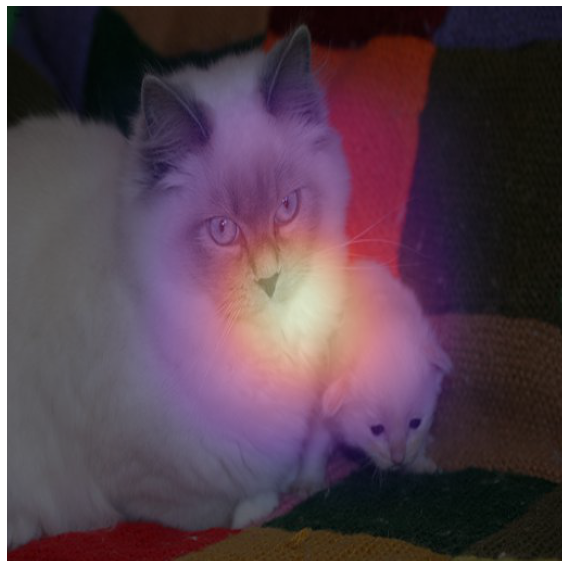

In [72]:
fig, (ax1) = plt.subplots(1,1) 
dls.train.decode((x_cat,))[0].squeeze().show(ax=ax1)
ax1.imshow((grad_cam_cat).to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='spline36',cmap='magma')
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

In [77]:
grad_cam_cat_r = score_cam(lrnr2_r.model.to('cpu'), img_cat_r, class_index=1)  # ResNet-34에서는 layer4를 사용

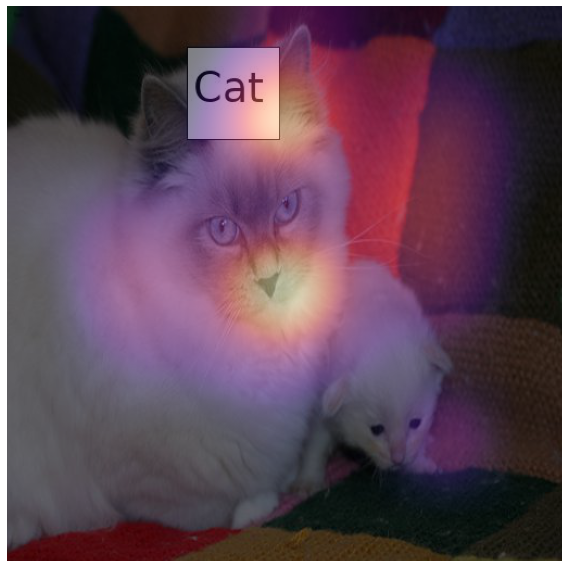

In [78]:
fig, (ax1) = plt.subplots(1,1) 
dls.train.decode((x_cat_r,))[0].squeeze().show(ax=ax1)
ax1.imshow((grad_cam_cat_r).to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='spline36',cmap='magma')
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

In [81]:
grad_cam_dog = score_cam(lrnr2.model.to('cpu'), img_dog, class_index=1)  # ResNet-34에서는 layer4를 사용

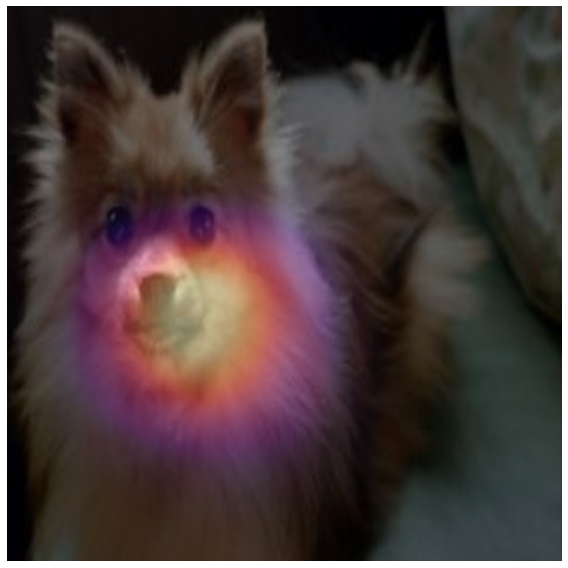

In [82]:
fig, (ax1) = plt.subplots(1,1) 
dls.train.decode((x_dog,))[0].squeeze().show(ax=ax1)
ax1.imshow((grad_cam_dog).to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='spline36',cmap='magma')
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

In [94]:
grad_cam_dog_r = score_cam(lrnr2_r.model.to('cpu'), img_dog_r, class_index=1)

In [95]:
grad_cam_dog_r

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1389, 0.4988, 0.6678, 0.3931, 0.0012, 0.0000],
        [0.0000, 0.2094, 0.6792, 0.9307, 0.6193, 0.1842, 0.0000],
        [0.0000, 0.2330, 0.6546, 0.8194, 0.4580, 0.0776, 0.0000],
        [0.0000, 0.0000, 0.1763, 0.3683, 0.2077, 0.0029, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],
       grad_fn=<ClampBackward1>)

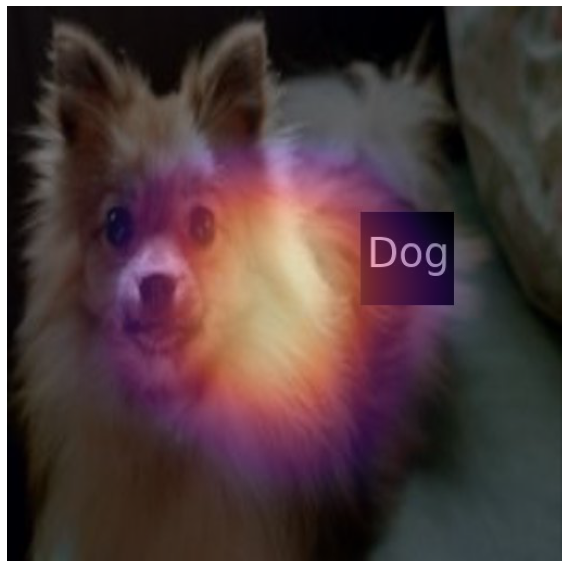

In [88]:
fig, (ax1) = plt.subplots(1,1) 
dls.train.decode((x_dog_r,))[0].squeeze().show(ax=ax1)
ax1.imshow((grad_cam_dog_r).to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='spline36',cmap='magma')
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()